In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
from sklearn.linear_model import Ridge
import random
import copy
import scipy
import sklearn.metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class linear_nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(linear_nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.D_out)
    
    def forward(self, x):
        x = self.l1(x) #linear weights for model interpretability
        return(x)

#learn A, for a fixed A, I have the error outputs, true values
#of this function are the 1/2 A_true vs A_fault
class decision_boundary_nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(decision_boundary_nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.H1 = params['HIDDEN_1']
        self.H2 = params['HIDDEN_2']
        self.H3 = params['HIDDEN_3']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.H2)
        self.l3 = nn.Linear(self.H2, self.H3)
        self.l4 = nn.Linear(self.H3, self.D_out)
        self.M = nn.LogSoftmax()
    
    def forward(self, x):
        x = F.sigmoid(self.l1(x))
        x = F.sigmoid(self.l2(x))
        x = F.sigmoid(self.l3(x))
        #x = M(self.l4(x))
        return(x)

In [3]:
#Bayesian classifier
def mat_C(x):
    #x shape = px1
    C = np.dot(x, x.T) + np.eye(x.shape[0])
    return(C)

def mat_D(x, y, A):
    #x shape px1, y shape nx1, A nxp
    D = np.dot(y, x.T) + A
    return(D)

def likelihood_point(x, y, A):
    C = mat_C(x)
    D = mat_D(x, y, A)
    const = x.shape[0]*np.log(np.linalg.det(np.linalg.inv(C)))
    var = np.trace(y.dot(y.T) - 2*A.dot(x).dot(y.T) + x.T.dot(A.T).dot(A).dot(x))
    var2 = np.trace(y.dot(y.T) + A.dot(A.T) - D.dot(np.linalg.inv(C)).dot(D.T))   #mixed term doesn't look right
    out = var - var2 + const
    return(out)

In [4]:
#features to ignore"
ignore = ["Performance Curve Input Variable 1 Value [] !Each Call", "Performance Curve Output Value [] !Each Call"]

#def parse_line()

def read_data_dictionary(lines):
    data_dict = {}
    for line in lines:
        l = line.strip()
        if l == "End of Data Dictionary":
            break
        else:
            tokens = l.split(",")
            if int(tokens[0]) == 2:
                data_dict[int(tokens[0])] = tokens[1:]
                #parse time dictionary line
            elif int(tokens[0]) > 6 and int(tokens[1]) == 1:
                if tokens[-1] in ignore:
                    pass
                elif len(tokens) == 4:
                    data_dict[int(tokens[0])] = tokens[-2] + tokens[-1]
                    
                else:
                    #parse value dictionary line
                    data_dict[int(tokens[0])] = tokens[-1]
            else:
                pass
    return(data_dict)

def parse_time_line(line_str):
    #2,8,Day of Simulation[],Month[],Day of Month[],DST Indicator[1=yes 0=no],Hour[],StartMinute[],EndMinute[],DayType
    #2, 1, 1, 1, 0, 1, 0.00, 2.00, Holiday
    #only want hourly times, multiple minute 2's, assuming got correct
    tokens = line_str.strip().split(",")
    minute=float(tokens[-3])
    hour=int(tokens[-4])
    day=int(tokens[-6])
    month=int(tokens[-7])
    return(datetime.datetime(2017, month, day, hour-1, 0, 0)) #2017 so that the 1st is a Sunday + not leapyear
    #return(str(month) + "/" + str(day) + " " + str(hour) + ":00")
     
def parse_lines(lines, feature_inds):
    data_values = {}
    data_values[2] = []
    for i in feature_inds:
        data_values[i] = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                data_values[2].append(t)
        elif int(tokens[0]) in feature_inds:
            data_values[int(tokens[0])].append(float(tokens[-1]))
        else:
            pass
    return(data_values)
    #return hourly list for all feature vars, plus hourly list with times to check sorting
    
def get_holidays(lines):
    holidays = []
    weekends = []
    all_dates = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if tokens[-1] == "Holiday":
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                holidays.append(t)
        elif int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                all_dates.append(t)
                if t.weekday() == 6 or t.weekday() == 0:
                    weekends.append(t)
    return(all_dates, weekends, holidays)
                      
def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def read_total_data_array(filepath, dep_var_names, ind_var_names, zone_temp_inds, first_diff=False, no_weekend_holiday=False):
    with open(datapath + filepath) as d:
        lines = d.readlines()
        lines.pop(0)
        data_dict = read_data_dictionary(lines)
        data = parse_lines(lines, data_dict)
        all_dates, weekends, holidays = get_holidays(lines)
        ind_map = {}
        for key, value in data_dict.items():
            if type(value) == list:
                value = value[-1]
            ind_map[value] = key

    X = np.zeros((len(dep_var_names) + len(zone_temp_inds), 8760))
    U = np.zeros((len(ind_var_names), 8760))

    for i in range(len(ind_var_names)):
        item = ind_var_names[i]
        ind = ind_map[item]
        if item == 'DayType':
            lis = data[ind]
            out = []
            for val in lis:
                out.append(val.weekday())
            arr = np.array(out)
        else:
            arr = np.array(data[ind])
        U[i,:] = arr

    for j in range(len(dep_var_names)):
        item = dep_var_names[j]
        ind = ind_map[item]
        arr = np.array(data[ind])
        X[j,:] = arr

    for j in range(len(zone_temp_inds)):
        ind = zone_temp_inds[j]
        arr = np.array(data[ind])
        X[j+len(dep_var_names),:] = arr
        
    if no_weekend_holiday == True:
        weekend_i = []
        holiday_i = []
        for j in range(len(all_dates)):
            if all_dates[j] in weekends:
                weekend_i.append(j)
            if all_dates[j] in holidays:
                holiday_i.append(j)
                
        del_i = np.array(list(set(holiday_i + weekend_i)))
        X = np.delete(X, del_i, axis=1)
        U = np.delete(U, del_i, axis=1)
    
    if first_diff == True:
        X = np.diff(X, n=1, axis=1)
        U = np.diff(U, n=1, axis=1)

    Z = np.vstack((X, U))

    return(Z, X, U)

def minibatch_X_Y_arrays(X_arr, Y_arr, batchsize):    
    #list of training, target pair tuples
    remainder = X_arr.shape[1] % batchsize
    diff = batchsize - remainder
    tail_X = X_arr[:,-diff:] 
    tail_Y = Y_arr[:,-diff:]
    out_X = [ X_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(X_arr.shape[1])/float(batchsize))) ]
    out_Y = [ Y_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(Y_arr.shape[1])/float(batchsize)))]
    out_X = out_X + [tail_X]
    out_Y = out_Y + [tail_Y]
    return(out_X, out_Y)

def split_train_val(Z, X, U, order=1, shuff=True, split_prop=0.8):
    all_pairs = []
    for i in range(Z.shape[1] - order):  #not 8760 for first-diff
        all_pairs.append((Z[:,i:i+order-1].flatten(), Z[0:-U.shape[0],i+order]))

    if shuff == True:
        random.shuffle(all_pairs) 
    else:
        pass

    train_pairs = all_pairs[0:int(split_prop*len(all_pairs))]
    val_pairs = all_pairs[-int((1.0-split_prop)*len(all_pairs)):]
    
    #normalize to training data
    X_train = []
    Y_train = []

    for item in train_pairs:
        X_train.append(item[0])
        Y_train.append(item[1])

    X_val = []
    Y_val = []
    for item in val_pairs:
        X_val.append(item[0])
        Y_val.append(item[1])

    X_train = np.asarray(X_train).T
    Y_train = np.asarray(Y_train).T

    X_val = np.asarray(X_val).T
    Y_val = np.asarray(Y_val).T
    
    return(X_train, Y_train, X_val, Y_val)

def normalize_data_set(X, Y, X_minmax_vals):
    X_norm = copy.copy(X)
    Y_norm = copy.copy(Y)
    
    for row in range(X.shape[0]):
        mx = np.max(X_minmax_vals[row,:])
        mn = np.min(X_minmax_vals[row,:])

        X_norm[row,:] = (1.0/(mx - mn))*(X[row,:] - mn)

        if row < Y.shape[0]:
            Y_norm[row,:] = (1.0/(mx - mn))*(Y[row,:] - mn)
            
    return(X_norm, Y_norm)

def polynomial_kernel_mat(X, poly_degree):
    out = X
    for d in range(2,poly_degree+1):
        out = np.vstack((out, np.power(X, d)))
    return(out)

In [8]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
#dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
dep_var_names = ['Fans:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly']#, 'DayType']

poly_degree = 3 #5 is optimal with full order 26 from cross validation
order = 6

### Train A on full year, assume true A

Train A on the full year, assume true A, learn decision boundary. Transfer A with small # of samples. Train new decision boundary with those samples + transfered A. Test.

In [9]:
#building specific var names

zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

In [10]:
#need to cross-validate polynomial degree here

In [11]:
X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

params = {'FEATURE_DIM': X_val_poly.shape[0], 'OUTPUT_DIM': Y_val_pre.shape[0]}
net = linear_nnet(params)
loss_func = nn.MSELoss()#SmoothL1Loss()
optimizer = optim.SGD(net.parameters(),lr=0.01, momentum=0.9)
epochs = 1000
batch_size = 100

for e in range(epochs):
    training_losses = []
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_poly, Y_train, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T))
        label = Variable(torch.Tensor(Y_train_list[i[0]].T))

        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()

inp_val = Variable(torch.Tensor(X_val_poly.T))
label_val = Variable(torch.Tensor(Y_val.T))
out_val = net(inp_val)
loss_val = loss_func(out_val, label_val)
mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
print("Validation MSE: ", loss_val)
print("Validation MAPE: ", mape_val)

Validation MSE:  tensor(0.0027, grad_fn=<MseLossBackward>)
Validation MAPE:  inf


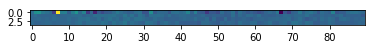

In [12]:
A = copy.copy(net.l1.weight.data.numpy())
plt.imshow(A)
plt.show()

In [15]:
errs[0].shape

(4,)

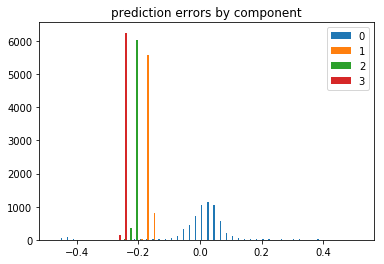

In [18]:
#compute the distribution of the forecast error
errs = []
for i in range(X_val_poly.shape[1]-1): 
    errs.append(A.dot(X_val_poly[:,i]) - Y_val[:,i])
    
plt.hist(np.asarray(errs), bins=50, label=["0", "1", "2", "3"])
plt.title("prediction errors by component")
plt.legend()
plt.show()

In [19]:
#compute the errors for the fault data and the fault-less data in fan operations

In [20]:
zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [21]:
zone_temp_inds = [863,864,865]

Z_f, X_f, U_f = read_total_data_array("refbuild_med_airfault/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_all_pre_f, Y_all_pre_f, X_v_f, Y_v_f = split_train_val(Z_f, X_f, U_f, order=order, shuff=False, split_prop=1.0)
X_all_f, Y_all_f = normalize_data_set(X_all_pre_f, Y_all_pre_f, X_all_pre)

#kernelize
X_all_poly_f = polynomial_kernel_mat(X_all_f, poly_degree)

In [29]:
#fault classification with Bayesian classifier
no_fault = []
fault = []
diff = []

fault_sum = [0.0]
nf_sum = [0.0]

for i in range(X_all_poly.shape[1]-1):
    nf = likelihood_point(np.expand_dims(X_all_poly[:,i], axis=1), np.expand_dims(Y_all[:,i], axis=1), A)
    f = likelihood_point(np.expand_dims(X_all_poly[:,i], axis=1), np.expand_dims(Y_all_f[:,i], axis=1), A)
    no_fault.append(nf)
    fault.append(f)
    diff.append(f - nf)
    
    fault_sum.append(fault_sum[-1] + f)
    nf_sum.append(nf_sum[-1] + nf)

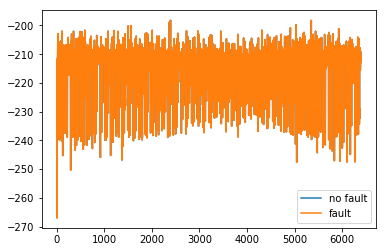

In [30]:
plt.plot(no_fault, label="no fault")
plt.plot(fault, label="fault")
plt.legend()
plt.show()

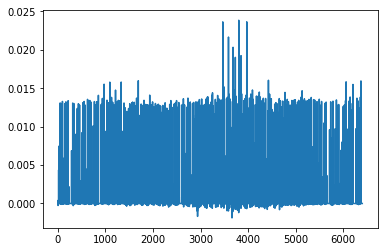

In [31]:
plt.plot(diff)
plt.show()

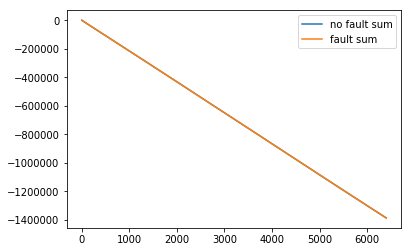

In [32]:
plt.plot(nf_sum, label="no fault sum")
plt.plot(fault_sum, label="fault sum")
plt.legend()
plt.show()

In [33]:
#use inputs to classification rule as features; try logistic regression classifier

#generate each of the terms in the linear combination

X = []
Y = []

for i in range(X_all_poly.shape[1]):
    if i % 1000 == 0:
        print("No fault data: ", np.around(100*(i/X_all_poly.shape[1])), "%")
    x = np.expand_dims(X_all_poly[:,i], axis=1)
    y = np.expand_dims(Y_all[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1), x and y themselves seem to be a waste
    X.append(features_app)
    Y.append(0)
    
for i in range(X_all_poly_f.shape[1]):
    if i % 1000 == 0:
        print("Fault data: ", np.around(100*(i/X_all_poly.shape[1])), "%")
    x = np.expand_dims(X_all_poly[:,i], axis=1) #tried with fault data
    y = np.expand_dims(Y_all_f[:,i], axis=1)
    C = mat_C(x)
    D = mat_D(x, y, A)
    C_inv = np.linalg.inv(C)
    term1 = x.shape[0]*np.log(np.linalg.det(C_inv))
    term2 = np.trace(C_inv.dot(D.T).dot(D))
    term3 = -1.0*np.trace(A.dot(A.T))
    term4 = -2.0*np.trace(A.dot(x).dot(y.T))
    term5 = np.trace(x.T.dot(A.T).dot(A).dot(x))

    feat = [term1, term2, term3, term4, term5]
    features_app = np.asarray(feat)#(feat + list(x[:,0]) + list(y[:,0])) #np.expand_dims(A.flatten(), axis=1)
    X.append(features_app)
    Y.append(1)
    
X = np.asarray(X)
Y = np.asarray(Y)

No fault data:  0.0 %
No fault data:  16.0 %
No fault data:  31.0 %
No fault data:  47.0 %
No fault data:  62.0 %
No fault data:  78.0 %
No fault data:  94.0 %
Fault data:  0.0 %
Fault data:  16.0 %
Fault data:  31.0 %
Fault data:  47.0 %
Fault data:  62.0 %
Fault data:  78.0 %
Fault data:  94.0 %


In [34]:
Y = np.expand_dims(Y, axis=1)
X = X.T
Y = Y.T

#Y = np.asarray(Y)
#X = np.asarray(X.T)

print(X.shape, Y.shape)

(5, 12802) (1, 12802)


In [35]:
#X = np.loadtxt("nobuildelec_ord26_poly5_class_features.txt", delimiter=",")
#Y = np.loadtxt("nobuildelec_ord26_poly5_labels.txt", delimiter=",")

#X = X.T
#Y = np.expand_dims(Y, axis=0)


In [36]:
print(X.shape, Y.shape)

(5, 12802) (1, 12802)


In [37]:
nofault_samps = []
fault_samps = []

for i in range(X.shape[1]):
    if Y[0,i] == 0:
        nofault_samps.append(X[:,i])
    else:
        fault_samps.append(X[:,i])
        
        
lag = 100

X_lag_nf = np.zeros((lag*X.shape[0], len(nofault_samps) - lag))
Y_lag_nf = np.zeros((1, len(nofault_samps) - lag))

X_lag_f = np.zeros((lag*X.shape[0], len(fault_samps) - lag))
Y_lag_f = np.ones((1, len(fault_samps) - lag))

for i in range(len(nofault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(nofault_samps[i + j])
    X_lag_nf[:,i] = np.asarray(samps).flatten()
    
for i in range(len(fault_samps)-lag):
    samps = []
    for j in range(lag):
        samps.append(fault_samps[i + j])
    X_lag_f[:,i] = np.asarray(samps).flatten()

In [38]:
X = np.hstack((X_lag_nf, X_lag_f))
Y = np.concatenate((Y_lag_nf, Y_lag_f), axis=1)

In [39]:
Y.shape

(1, 12602)

In [44]:
train_vals = np.random.choice(X.shape[1], int(0.8*X.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X.shape[1]) if i not in train_vals ])

X_train_log_reg = X[:,train_vals] #X[:,train_vals]
Y_train_log_reg = Y[:,train_vals]

X_val_log_reg = X[:,vals]
Y_val_log_reg = Y[:,vals]

In [41]:
logreg_model_obj = LogisticRegression(tol=0.0001, C=0.9, max_iter=10000, verbose=1)#, n_jobs=-1, solver="saga")
logreg_model_obj.fit(X_train_log_reg.T, Y_train_log_reg.T)

Y_hat = logreg_model_obj.predict(X_train_log_reg.T)

p = sklearn.metrics.precision_score(Y_train_log_reg.T, Y_hat.T)
r = sklearn.metrics.recall_score(Y_train_log_reg.T, Y_hat.T)

print("Training precision: ", p)
print("Training recall: ", r)

Y_hat_val = logreg_model_obj.predict(X_val_log_reg.T)

p = sklearn.metrics.precision_score(Y_val_log_reg.T, Y_hat_val.T)
r = sklearn.metrics.recall_score(Y_val_log_reg.T, Y_hat_val.T)

print("Validation precision: ", p)
print("Validation recall: ", r)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]Training precision:  0.6217776067718354
Training recall:  0.6377269139700079
Validation precision:  0.5085536547433903
Validation recall:  0.5304136253041363


In [45]:
#classify a elements of a sequence, +1 if fualt, -1 if no fault

fault_votes = [0.0]
nofault_votes = [0.0]
base = [0.0]

for i in range(X_val_log_reg.shape[1]):
    #if no fault
    if Y_val_log_reg[0,i] == 0:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            nofault_votes.append(nofault_votes[-1] - 1)
        if Y_hat == 1:
            nofault_votes.append(nofault_votes[-1] + 1)
    #if fault
    if Y_val_log_reg[0,i] == 1:
        Y_hat = logreg_model_obj.predict(X_val_log_reg[:,i].T.reshape(1, -1))
        if Y_hat == 0:
            fault_votes.append(fault_votes[-1] - 1)
        if Y_hat == 1:
            fault_votes.append(fault_votes[-1] + 1)
        base.append(base[-1] + 0.5)

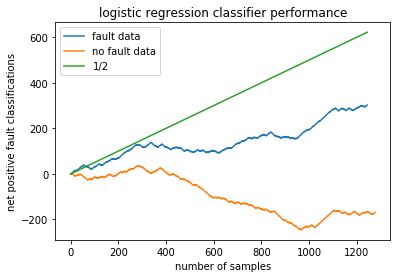

In [46]:
plt.plot(fault_votes, label="fault data")
plt.plot(nofault_votes, label="no fault data")
plt.plot(base, label="1/2")
plt.ylabel("net positive fault classifications")
plt.xlabel("number of samples")
plt.title("logistic regression classifier performance")
plt.legend()
plt.show()

In [43]:
#NN classifier

In [64]:
Y_train_log_reg.shape

(1, 10209)

In [97]:
Y_train_nn = np.zeros((2, Y_train_log_reg.shape[1]))
Y_val_nn = np.zeros((2, Y_val_log_reg.shape[1]))

for i in range(Y_train_log_reg.shape[1]):
    if Y_train_log_reg[0,i] == 0:
        Y_train_nn[0,i] = 1.0
    if Y_train_log_reg[0,i] == 1:
        Y_train_nn[1,i] = 1.0

for i in range(Y_val_log_reg.shape[1]):
    if Y_val_log_reg[0,i] == 0:
        Y_val_nn[0,i] = 1.0
    if Y_val_log_reg[0,i] == 1:
        Y_val_nn[1,i] = 1.0

In [105]:
params = {'FEATURE_DIM': X_train_log_reg.shape[0], 'HIDDEN_1': 2*X_train_log_reg.shape[0], 'HIDDEN_2': 2*X_train_log_reg.shape[0], 'HIDDEN_3': int(0.5*X_train_log_reg.shape[0]), 'OUTPUT_DIM': 1}
dnet = decision_boundary_nnet(params).cuda()
loss_func = nn.BCELoss()
optimizer = optim.SGD(dnet.parameters(),lr=0.001, momentum=0.9)
batch_size = 100

In [106]:
epochs = 5000

for e in range(epochs):
    training_losses = []
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_log_reg, Y_train_nn, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T)).cuda()
        label = Variable(torch.Tensor(Y_train_list[i[0]].T)).cuda()

        out = dnet(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    if e % 100 == 0:
        print("epoch ", e, " training loss: ", np.mean(training_losses))

        inp_val = Variable(torch.Tensor(X_val_log_reg.T)).cuda()
        label_val = Variable(torch.Tensor(Y_val_nn.T)).cuda()
        out_val = dnet(inp_val)
        loss_val = loss_func(out_val, label_val)
        #mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
        print("\n\t validation loss: ", loss_val)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch  0  training loss:  0.6949152448802318

	 validation loss:  tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch  100  training loss:  0.6931624047964522

	 validation loss:  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch  200  training loss:  0.6931623926440489

	 validation loss:  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch  300  training loss:  0.693162392065363

	 validation loss:  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
epoch  400  training loss:  0.6931623938014206

	 validation loss:  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


KeyboardInterrupt: 

In [107]:
#classify a elements of a sequence, +1 if fualt, -1 if no fault

fault_votes = [0.0]
nofault_votes = [0.0]
base = [0.0]
fault_vals = [0.0]
nofault_vals = [0.0]

for i in range(X_val_log_reg.shape[1]):
    #if no fault
    if Y_val_log_reg[0,i] == 0:
        inp_val = Variable(torch.Tensor(X_val_log_reg[:,i].T.reshape(1, -1))).cuda()
        #Y_hat = dnet(inp_val).item()
        #nofault_vals.append(Y_hat + nofault_vals[-1])
        Y_hat = np.argmax(out_val.cpu().data.numpy())
        if Y_hat == 0:
            nofault_votes.append(nofault_votes[-1] - 1)
        if Y_hat == 1:
            nofault_votes.append(nofault_votes[-1] + 1)
    #if fault
    if Y_val_log_reg[0,i] == 1:
        inp_val = Variable(torch.Tensor(X_val_log_reg[:,i].T.reshape(1, -1))).cuda()
        #Y_hat = dnet(inp_val).item()
        #fault_vals.append(Y_hat + fault_vals[-1])
        Y_hat = np.argmax(out_val.cpu().data.numpy())
        if Y_hat == 0:
            fault_votes.append(fault_votes[-1] - 1)
        if Y_hat == 1:
            fault_votes.append(fault_votes[-1] + 1)
        base.append(base[-1] + 0.5)

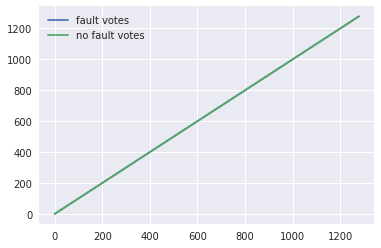

In [108]:
plt.plot(fault_votes, label="fault votes")
plt.plot(nofault_votes, label="no fault votes")
plt.legend()
plt.show()

In [ ]:
plt.plot(fault_votes, label="fault data")
plt.plot(nofault_votes, label="no fault data")
plt.plot(base, label="1/2")
plt.ylabel("net positive fault classifications")
plt.xlabel("number of samples")
plt.title("logistic regression classifier performance")
plt.legend()
plt.show()

In [144]:
Y_out_f = []
Y_out = []

for i in range(X_all_poly.shape[1]):  #arbitrary time of year
    var_term = np.power(A.dot(X_all_poly[:,i]) - Y_all[:,i],2)[1]
    var_term_f = np.power(A.dot(X_all_poly_f[:,i]) - Y_all_f[:,i],2)[1]
    lesser = np.min([var_term_f, var_term])

    #dnet for fan only
    Y_out_f.append(lesser + (0.5*np.abs(var_term - var_term_f)))
    Y_out.append(lesser + (0.5*np.abs(var_term - var_term_f)))
    
Y_out_f = np.expand_dims(np.asarray(Y_out_f), axis=0)
Y_out = np.expand_dims(np.asarray(Y_out), axis=0)

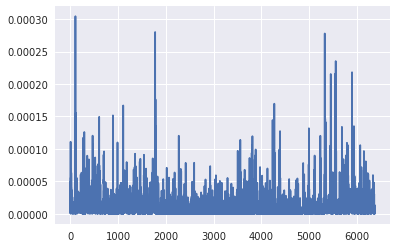

1.2771350354296085e-05


In [145]:
plt.plot(Y_out_f[0,:])
plt.show()
print(np.mean(Y_out_f[0,:]))

In [170]:
params = {'FEATURE_DIM': X_all_poly.shape[0], 'HIDDEN_1': 2*X_all_poly.shape[0], 'HIDDEN_2': 2*X_all_poly.shape[0], 'HIDDEN_3': int(0.5*X_all_poly.shape[0]), 'OUTPUT_DIM': 1}
dnet = decision_boundary_nnet(params).cuda()
loss_func = nn.MSELoss()#SmoothL1Loss()
optimizer = optim.SGD(dnet.parameters(),lr=1e-5, momentum=0.9)
batch_size = 100

In [171]:
X_all_boundary_func = np.hstack((X_all_poly, X_all_poly_f))
Y_all_boundary_func = np.hstack((Y_out, Y_out_f))

In [172]:
train_vals = np.random.choice(X_all_boundary_func.shape[1], int(0.8*X_all_boundary_func.shape[1]), replace=False)
vals = np.asarray([ i for i in range(X_all_boundary_func.shape[1]) if i not in train_vals ])

X_train_boundary_func = X_all_boundary_func[:, train_vals]
Y_train_boundary_func = Y_all_boundary_func[:, train_vals]

X_val_boundary_func = X_all_boundary_func[:, vals]
Y_val_boundary_func = Y_all_boundary_func[:, vals]

In [173]:
epochs = 5000

for e in range(epochs):
    training_losses = []
    X_train_list, Y_train_list = minibatch_X_Y_arrays(X_train_boundary_func, Y_train_boundary_func, batch_size)
    for i in enumerate(X_train_list):
        inp = Variable(torch.Tensor(X_train_list[i[0]].T)).cuda()
        label = Variable(torch.Tensor(Y_train_list[i[0]].T)).cuda()

        out = dnet(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    if e % 100 == 0:
        print("epoch ", e, " training loss: ", np.mean(training_losses))

        inp_val = Variable(torch.Tensor(X_val_boundary_func.T)).cuda()
        label_val = Variable(torch.Tensor(Y_val_boundary_func.T)).cuda()
        out_val = dnet(inp_val)
        loss_val = loss_func(out_val, label_val)
        #mape_val = torch.mean(torch.abs(out_val - label_val)/label_val).item()
        print("\n\t validation MSE: ", loss_val)


/home/chase/applications/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch  0  training loss:  0.016094754077576264

	 validation MSE:  tensor(2.5217e-06, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  100  training loss:  1.5934187751346913e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  200  training loss:  1.5934166236733737e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  300  training loss:  1.593412343170776e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  400  training loss:  1.5934114696516118e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  500  training loss:  1.5933857193759137e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  600  training loss:  1.59339163567896e-08

	 validation MSE:  tensor(1.5088e-08, device='cuda:0', grad_fn=<MseLossBackward>)
epoch  700  training loss:  1.593393932008214e-08

	 validation MSE: 

KeyboardInterrupt: 

In [181]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

dnet_fault_vals = []
dnet_vals = []

for i in range(X_all_poly.shape[1]-1):  #arbitrary time of year
    
    samp_x = X_all_poly[:,i]
    samp_y = Y_all[:,i]
    
    #samp_x_t = Variable(torch.Tensor(samp_x)).unsqueeze(-1).cuda().transpose(1,0)
    
    samp_x_f = X_all_poly_f[:,i]
    samp_y_f = Y_all_f[:,i]
    
    e_lkhds.append(np.power(A.dot(samp_x) - samp_y,2)[0] - dnet(Variable(torch.Tensor(samp_x)).cuda()).item())
    e_lkhds_fault.append(np.power(A.dot(samp_x_f) - samp_y_f,2)[0] - dnet(Variable(torch.Tensor(samp_x_f)).cuda()).item())
    
    f_lkhds.append(np.power(A.dot(samp_x) - samp_y,2)[1] - dnet(Variable(torch.Tensor(samp_x)).cuda()).item())
    f_lkhds_fault.append(np.power(A.dot(samp_x_f) - samp_y_f,2)[1] - dnet(Variable(torch.Tensor(samp_x_f)).cuda()).item())
    
    dnet_fault_vals.append(dnet(Variable(torch.Tensor(samp_x_f)).cuda()).item())
    dnet_vals.append(dnet(Variable(torch.Tensor(samp_x)).cuda()).item())
    

/home/chase/applications/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


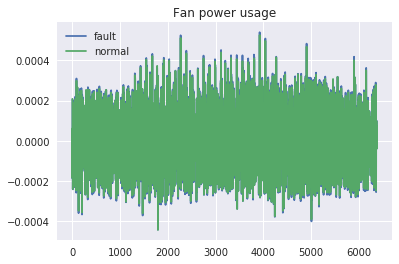

In [180]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

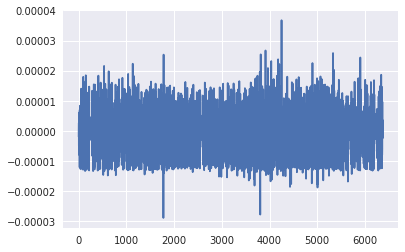

-2.548650245451661e-07


In [176]:
plt.plot(np.asarray(f_lkhds_fault) - np.asarray(f_lkhds))
plt.show()
print(np.mean(np.asarray(f_lkhds_fault) - np.asarray(f_lkhds)))

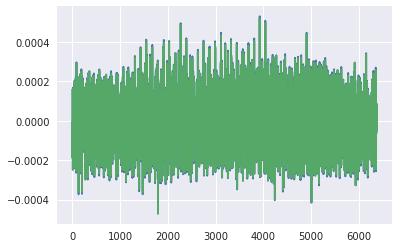

1.1803659093697617e-05


In [177]:
plt.plot(dnet_fault_vals)
plt.plot(dnet_vals)
plt.show()
print(np.mean(dnet_vals))

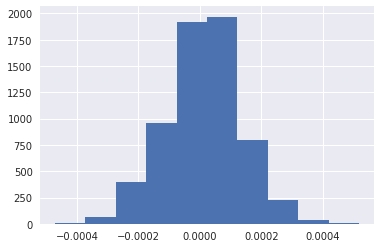

In [178]:
plt.hist(dnet_vals)
plt.show()

In [ ]:
#need to do some hyperparameter sweeps on degree, lag, order for classification prec/rec